In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from itertools import product

In [65]:
# Functions for feature engineering
def prepare_game_features_v3(final_log, train_window=3):
    """
    Generate features using all available columns in the dataset, including career stats, 
    recent game stats, and rankings.
    """
    rows = []
    games = final_log['Game_ID'].unique()
    for game_id in tqdm(games, desc="Processing games"):
        game_data = final_log[final_log['Game_ID'] == game_id]
        if game_data.empty:
            continue

        team1, team2 = game_data.iloc[0]['TEAM_ABBR'], game_data.iloc[0]['OPPONENT_ABBR']
        team1_players = game_data[game_data['TEAM_ABBR'] == team1]['Player_ID'].unique()
        team2_players = game_data[game_data['TEAM_ABBR'] == team2]['Player_ID'].unique()

        # Aggregate features for both teams
        team1_features = aggregate_team_features(team1, team1_players, final_log, train_window, game_id)
        team2_features = aggregate_team_features(team2, team2_players, final_log, train_window, game_id)

        if not team1_features or not team2_features:
            continue

        # Generate interaction features dynamically
        interaction_features = {}
        for feature in team1_features.keys():
            if feature not in ['Offense_Defense_Interaction']:  # Skip special interaction features
                interaction_features[f"{feature}_diff"] = team1_features[feature] - team2_features[feature]

        # Combine all features into a single row
        row = {f"team1_{k}": v for k, v in team1_features.items()}
        row.update({f"team2_{k}": v for k, v in team2_features.items()})
        row.update(interaction_features)
        row['WL'] = game_data.iloc[0]['WL']  # Add win/loss label
        rows.append(row)

    return pd.DataFrame(rows)

def aggregate_team_features(team_name, player_ids, final_log, train_window, current_game):
    """
    Aggregate stats for a team considering recent games, career stats, rankings, and other attributes.
    """
    recent_games = final_log[
        (final_log['TEAM_ABBR'] == team_name) &
        (final_log['Game_ID'] < current_game) &
        (final_log['Player_ID'].isin(player_ids))
    ].sort_values(by='GAME_DATE', ascending=False).groupby('Player_ID').head(train_window)

    if recent_games.empty:
        return None

    # Aggregate stats including the new columns
    team_features = {
        # Aggregate recent game stats
        **{f"{col}_avg": recent_games[col].mean(skipna=True) for col in final_log.columns if col.endswith("_game")},
        **{f"{col}_sum": recent_games[col].sum(skipna=True) for col in final_log.columns if col.endswith("_game")},
        
        # Aggregate career stats
        **{f"{col}_avg": recent_games[col].mean(skipna=True) for col in final_log.columns if col.endswith("_career")},
        **{f"{col}_sum": recent_games[col].sum(skipna=True) for col in final_log.columns if col.endswith("_career")},
        
        # Aggregate rankings
        **{f"{col}_avg": recent_games[col].mean(skipna=True) for col in final_log.columns if col.endswith("_RANK")},
        **{f"{col}_sum": recent_games[col].sum(skipna=True) for col in final_log.columns if col.endswith("_RANK")},
        
        # Aggregate additional attributes
        "AGE_avg": recent_games["AGE"].mean(skipna=True),
        "GP_sum": recent_games["GP"].sum(skipna=True),
        "W_sum": recent_games["W"].sum(skipna=True),
        "L_sum": recent_games["L"].sum(skipna=True),
        "W_PCT_avg": recent_games["W_PCT"].mean(skipna=True),

        # Calculate additional interactions
        'Offense_Defense_Interaction': (recent_games['PTS_game'].sum(skipna=True) + recent_games['AST_game'].sum(skipna=True)) *
                                       (recent_games['REB_game'].sum(skipna=True) + recent_games['STL_game'].sum(skipna=True))
    }

    return team_features

In [94]:
# Function to build LSTM Model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [101]:
# Load and prepare data
final_log = pd.read_csv('final_log.csv')
final_log['GAME_DATE'] = pd.to_datetime(final_log['GAME_DATE'])

train_games = final_log[final_log['GAME_DATE'] < '2023-04-01']
test_games = final_log[final_log['GAME_DATE'] >= '2023-04-01']

train_features = prepare_game_features_v3(train_games)
test_features = prepare_game_features_v3(test_games)

X_train = train_features.drop(columns=['WL'])
y_train = train_features['WL']
X_test = test_features.drop(columns=['WL'])
y_test = test_features['WL']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Processing games: 100%|██████████| 1300/1300 [00:19<00:00, 66.77it/s]


In [106]:
# Train LightGBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_lgbm = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
lgbm_probs = best_lgbm.predict_proba(X_test_scaled)[:, 1]

C:\Users\15910\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\15910\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1758, number of negative: 1695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103164
[LightGBM] [Info] Number of data points in the train set: 3453, number of used features: 431
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509123 -> initscore=0.036494
[LightGBM] [Info] Start training from score 0.036494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\15910\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Train LSTM
param_grid = {
    'lstm_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.005],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

param_combinations = list(product(param_grid['lstm_units'], param_grid['dropout_rate'], param_grid['learning_rate'], param_grid['batch_size'], param_grid['epochs']))

best_auc = 0
best_params = None
best_model = None

for params in tqdm(param_combinations, desc="Grid Search Progress"):
    lstm_units, dropout_rate, learning_rate, batch_size, epochs = params

    lstm_model = build_lstm(input_shape=lstm_input_shape, lstm_units=lstm_units, dropout_rate=dropout_rate, learning_rate=learning_rate)

    history = lstm_model.fit(
        X_train_lstm, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    val_probs = lstm_model.predict(X_train_lstm[-len(X_train_lstm) // 5:]).flatten()
    val_auc = roc_auc_score(y_train[-len(y_train) // 5:], val_probs)

    if val_auc > best_auc:
        best_auc = val_auc
        best_params = params
        best_model = lstm_model

print("Best Parameters:", {
    'lstm_units': best_params[0],
    'dropout_rate': best_params[1],
    'learning_rate': best_params[2],
    'batch_size': best_params[3],
    'epochs': best_params[4]
})
print("Best Validation AUC:", best_auc)

lstm_probs = best_model.predict(X_test_lstm).flatten()

In [103]:
# Train LSTM
lstm_input_shape = (X_train_scaled.shape[1], 1)
X_train_lstm = X_train_scaled.reshape(-1, lstm_input_shape[0], lstm_input_shape[1])
X_test_lstm = X_test_scaled.reshape(-1, lstm_input_shape[0], lstm_input_shape[1])

lstm_model = build_lstm(input_shape=lstm_input_shape)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
lstm_probs = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/20


C:\Users\15910\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.5612 - loss: 0.6818 - val_accuracy: 0.6237 - val_loss: 0.6555
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.6318 - loss: 0.6477 - val_accuracy: 0.6223 - val_loss: 0.6347
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.6483 - loss: 0.6190 - val_accuracy: 0.6570 - val_loss: 0.6300
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.6611 - loss: 0.6202 - val_accuracy: 0.6454 - val_loss: 0.6350
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.6761 - loss: 0.6035 - val_accuracy: 0.6382 - val_loss: 0.6310
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.6569 - loss: 0.6171 - val_accuracy: 0.6541 - val_loss: 0.6279
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.6709 - loss: 0.6130 - val_accuracy: 0.6469 - val_loss: 0.6255
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 0.6618 - loss: 0.6129 - val_accuracy: 0.658

In [131]:
# Ensemble by weight blending
lgbm_weight = roc_auc_score(y_test, lgbm_probs) / (
    roc_auc_score(y_test, lgbm_probs) + roc_auc_score(y_test, lstm_probs)
)
lstm_weight = 1 - lgbm_weight
ensemble_probs = (lgbm_weight * lgbm_probs) + (lstm_weight * lstm_probs)

# Model evaluation
accuracy_ensemble = accuracy_score(y_test, (ensemble_probs > 0.43).astype(int))
roc_auc_ensemble = roc_auc_score(y_test, ensemble_probs)

print(f"Blended Model Accuracy: {accuracy_ensemble:.4f}")
print(f"Blended Model ROC-AUC: {roc_auc_ensemble:.4f}")

Blended Model Accuracy: 0.7072
Blended Model ROC-AUC: 0.7801


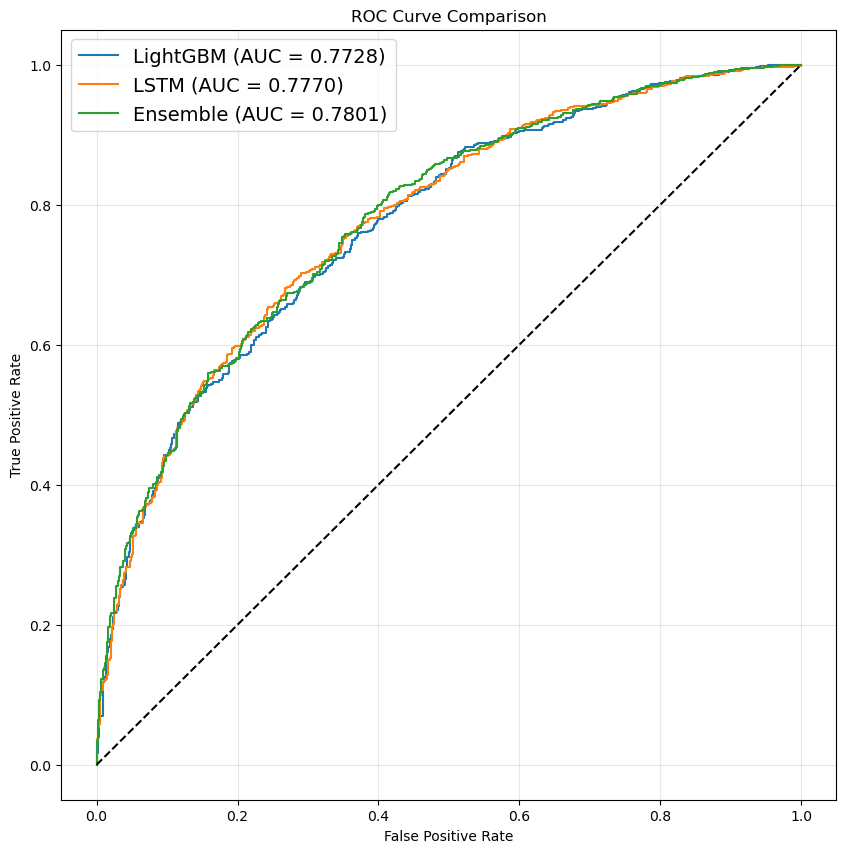

In [139]:
# ROC curves
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_probs)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_probs)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_probs)

plt.figure(figsize=(10, 10))
plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC = {roc_auc_score(y_test, lgbm_probs):.4f})")
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {roc_auc_score(y_test, lstm_probs):.4f})")
plt.plot(fpr_ensemble, tpr_ensemble, label=f"Ensemble (AUC = {roc_auc_ensemble:.4f})")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.show()

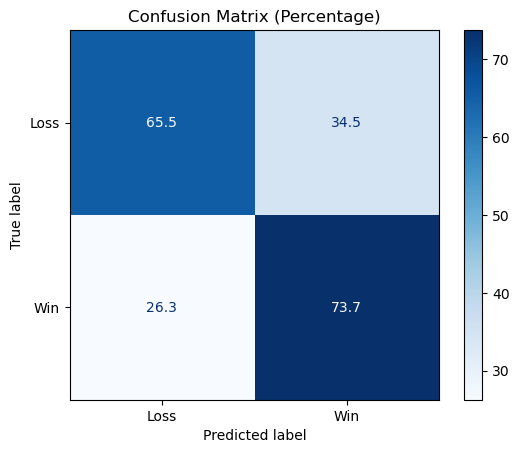

In [109]:
# Confusion matrix
cm = confusion_matrix(y_test, (ensemble_probs > 0.5).astype(int))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Loss', 'Win'])
disp.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix (Percentage)')
plt.show()

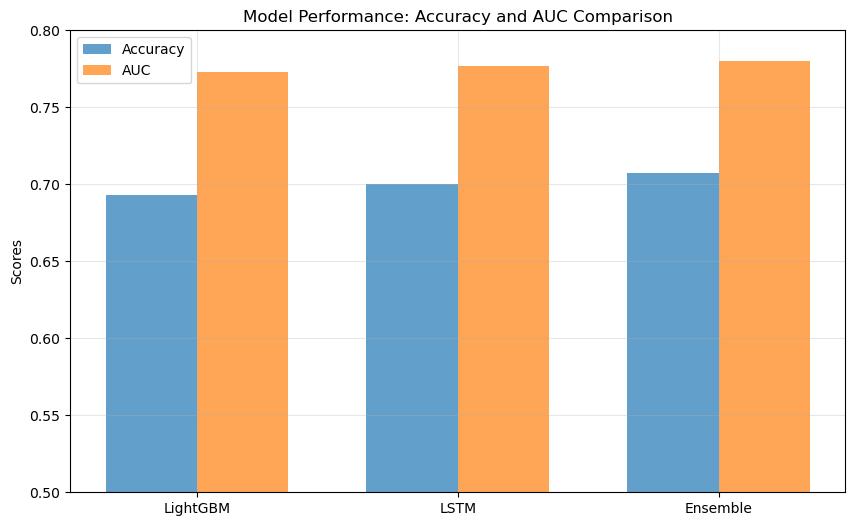

In [136]:
# Performance bar chart
methods = ['LightGBM', 'LSTM', 'Ensemble']
accuracy_values = [accuracy_score(y_test, (lgbm_probs > 0.5).astype(int)),
                   accuracy_score(y_test, (lstm_probs > 0.5).astype(int)),
                   accuracy_ensemble]
auc_values = [roc_auc_score(y_test, lgbm_probs), roc_auc_score(y_test, lstm_probs), roc_auc_ensemble]

x = range(len(methods))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, accuracy_values, width, label='Accuracy', alpha=0.7)
plt.bar([p + width for p in x], auc_values, width, label='AUC', alpha=0.7)
plt.xticks([p + width / 2 for p in x], methods)
plt.ylabel('Scores')
plt.title('Model Performance: Accuracy and AUC Comparison')
plt.legend()
plt.ylim(0.5, 0.8)
plt.grid(alpha=0.3)
plt.show()

In [137]:
import joblib
from tensorflow.keras.models import save_model
import pickle

# Save LightGBM model using joblib
joblib.dump(best_lgbm, 'best_lgbm.joblib')

# Save LSTM model using TensorFlow
save_model(lstm_model, 'lstm_model.h5')

# Save StandardScaler using pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)